In [1]:
import src.dataPipeline as dataPipeline
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import optuna

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
# Evaluating the model
from sklearn.metrics import mean_absolute_percentage_error,r2_score ,make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

importlib.reload(dataPipeline)


C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'src.dataPipeline' from 'C:\\Users\\wartm\\Documents\\FHNW\\immo_challenge\\src\\dataPipeline.py'>

In [2]:
dp = dataPipeline.DataPipeline()
df = dp.runPipeline(
    filePath="../data/immo_data_202208_v2.csv",
    imputer=None,
    normalizeAndStandardize= False,
    basic_house_imputer = True,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [3]:
df.head()

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,...,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group
0,On request,4.0,0.0,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,...,331.0,1150000.0,100.0,penthouse,0.0,5.0,NaN,NaN,1.0,60.0
1,On request,0.0,0.0,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,...,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,1.0,60.0
2,Immediately,2.0,0.0,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,...,33493.0,720000.0,93.0,penthouse,0.0,5.0,NaN,NaN,1.0,60.0
3,On request,0.0,0.0,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,...,331.0,1430000.0,154.0,detached-house,370.0,5.0,NaN,NaN,1.0,60.0
4,On request,0.0,0.0,NaN,0.333865,0.279276,0.145835,0.0,0.0,0.0,...,1355.0,995000.0,142.0,flat,0.0,5.0,NaN,NaN,1.0,60.0


In [4]:
df["region_group"] = df["region_group"].astype("category")
df["type_unified"] = df["type_unified"].astype("category")
df["Availability"] = df["Availability"].astype("category")

In [5]:
X = df.drop("price_cleaned", axis=1)
y = df["price_cleaned"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kategorische und numerische Spalten definieren
cat_col = ['region_group', 'type_unified', 'Availability']
numerical_features = [col for col in df.columns if col not in cat_col + ["price_cleaned"]]

# Preprocessing für numerische Daten
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),  # Fehlwerte auffüllen
    ('scaler', StandardScaler())  # Standardisieren
])

# Preprocessing für kategorische Daten
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot-Encoding
])

# ColumnTransformer erstellen
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, cat_col)
    ]
)

# Pipeline nur für das Preprocessing erstellen
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    # Create the base estimator
    base_estimator = DecisionTreeRegressor(max_depth=max_depth)

    # Create AdaBoostRegressor with the suggested hyperparameters
    model = AdaBoostRegressor(
        estimator=base_estimator,  # Changed from base_estimator to estimator
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )


    # Use K-Fold Cross Validation if dataset is large enough, otherwise use train-test split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_index, val_index in kf.split(X_train_transformed):
        X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_pred = model.predict(X_val_fold)

        # Evaluate the model using Mean Absolute Percentage Error
        mape = mean_absolute_percentage_error(y_val_fold, y_pred)
        mape_scores.append(mape)

    return sum(mape_scores) / len(mape_scores)

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=120)

# Output the best hyperparameters and score
print("Best parameters:", study.best_params)
print("Best MAPE:", study.best_value)

In [ ]:
# Train the best model with the optimal parameters
best_params = study.best_params
best_model = AdaBoostRegressor(
    base_estimator=DecisionTreeRegressor(max_depth=best_params["max_depth"]),
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)
best_model.fit(X_train_transformed, y_train)

# Evaluate the final model
final_mape = mean_absolute_percentage_error(y_test, best_model.predict(X_test_transformed))
print("Final MAPE with the best model:", final_mape)

# Price logaritmiert

In [7]:
y_test_log = np.log(y_test)
y_train_log = np.log(y_train)

In [19]:
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)
    max_depth = trial.suggest_int("max_depth", 1, 10)

    # Create the base estimator
    base_estimator = DecisionTreeRegressor(max_depth=max_depth)

    # Create AdaBoostRegressor with the suggested hyperparameters
    model = AdaBoostRegressor(
        estimator=base_estimator,  # Changed from base_estimator to estimator
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )


    # Use K-Fold Cross Validation if dataset is large enough, otherwise use train-test split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_index, val_index in kf.split(X_train_transformed):
        X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
        y_train_fold, y_val_fold = y_train_log.iloc[train_index], y_train_log.iloc[val_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_pred = model.predict(X_val_fold)

        # Evaluate the model using Mean Absolute Percentage Error
        mape = mean_absolute_percentage_error(np.exp(y_val_fold), np.exp(y_pred))
        mape_scores.append(mape)

    return sum(mape_scores) / len(mape_scores)

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=120)

# Output the best hyperparameters and score
print("Best parameters:", study.best_params)
print("Best MAPE:", study.best_value)


[I 2025-01-12 11:15:00,149] A new study created in memory with name: no-name-1bfe6661-91d1-499f-8409-82827aa1c24c
[I 2025-01-12 11:22:19,202] Trial 0 finished with value: 0.25551756086165794 and parameters: {'n_estimators': 106, 'learning_rate': 0.048839934063016316, 'max_depth': 9}. Best is trial 0 with value: 0.25551756086165794.


Best parameters: {'n_estimators': 106, 'learning_rate': 0.048839934063016316, 'max_depth': 9}
Best MAPE: 0.25551756086165794


In [20]:
optuna.visualization.plot_param_importances(study)

ValueError: Cannot evaluate parameter importances with only a single trial.

In [21]:
# Train the best model with the optimal parameters
best_params = study.best_params
best_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params["max_depth"]),
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)
best_model.fit(X_train_transformed, y_train_log)

# Evaluate the final model
test_mape = mean_absolute_percentage_error(y_test, np.exp(best_model.predict(X_test_transformed)))
print("Final MAPE with the best model:", test_mape)


Final MAPE with the best model: 0.3012302260088983


In [22]:
def get_feature_names(preprocessor):
    # Extract numerical feature names
    num_features = numerical_features

    # Extract categorical feature names after one-hot encoding
    cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_col)

    # Combine both
    return np.concatenate([num_features, cat_features])

# Extract feature names
feature_names = get_feature_names(preprocessor)

# Create a DataFrame with feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top10_importance = feature_importance_df.head(10)

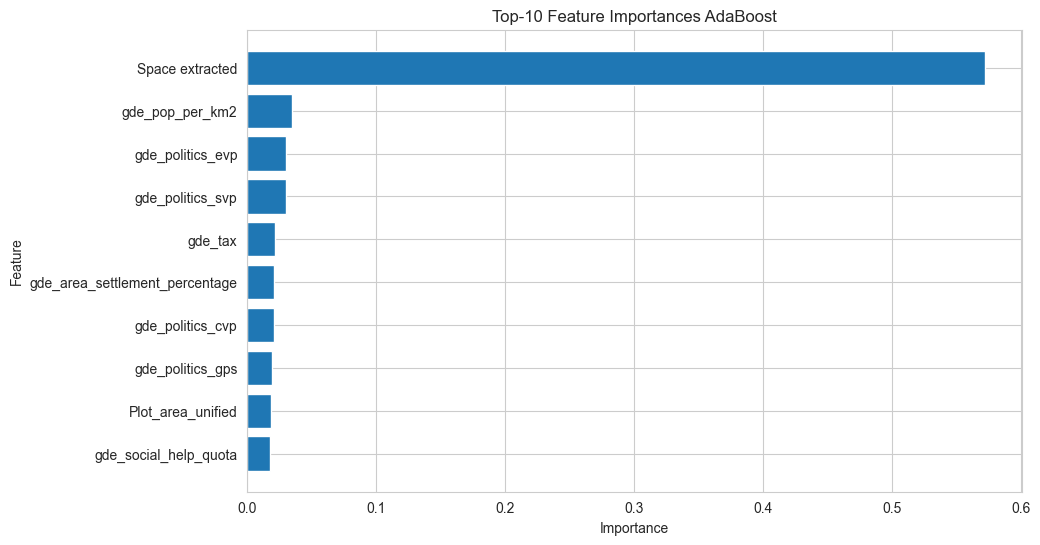

In [23]:
plt.figure(figsize=(10, 6))
plt.barh(top10_importance['Feature'], top10_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top-10 Feature Importances AdaBoost')
plt.gca().invert_yaxis()  # Most important at the top
plt.show()

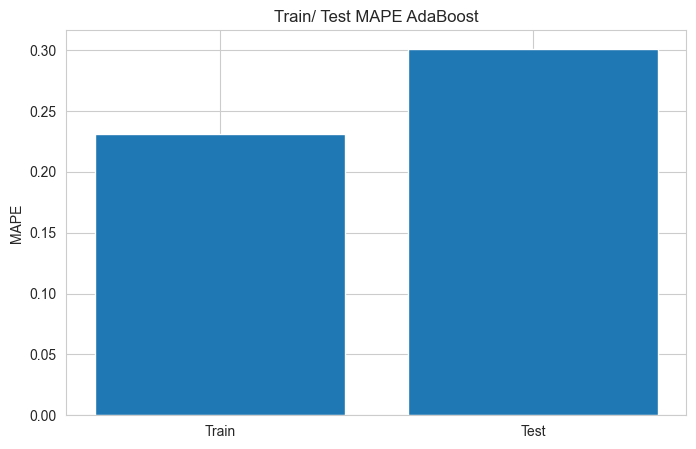

In [24]:
train_mape = mean_absolute_percentage_error(np.exp(y_train_log), np.exp(best_model.predict(X_train_transformed)))
#plot mape
plt.figure(figsize=(8, 5))
plt.bar(["Train", "Test"], [train_mape, test_mape])
plt.ylabel("MAPE")
plt.title("Train/ Test MAPE AdaBoost")
plt.show()


# Mehr Hyperparameter

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Create the base estimator
    base_estimator = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )

    # Create AdaBoostRegressor
    model = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )


    # Use K-Fold Cross Validation if dataset is large enough, otherwise use train-test split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_index, val_index in kf.split(X_train_transformed):
        X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
        y_train_fold, y_val_fold = y_train_log.iloc[train_index], y_train_log.iloc[val_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_pred = model.predict(X_val_fold)

        # Evaluate the model using Mean Absolute Percentage Error
        mape = mean_absolute_percentage_error(np.exp(y_val_fold), np.exp(y_pred))
        mape_scores.append(mape)

    return sum(mape_scores) / len(mape_scores)

# Create a study and optimize the objective function
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, timeout=180)

# Output the best hyperparameters and score
print("Best parameters:", study.best_params)
print("Best MAPE:", study.best_value)


# Kaggle Wetbewerb

In [ ]:
df_kaggle = dp.prepare_kaggle_dataset(
    filePath="../data/test_data-Kaggle-v0.11.csv",
    imputer=None,
    normalizeAndStandardize=False,
    basic_house_imputer=True,
    get_dummies=False
)
df_kaggle.head()

In [ ]:
df_kaggle = df_kaggle.drop(['Type:', 'Hall height:'], axis=1)

In [ ]:
df_kaggle["region_group"] = df_kaggle["region_group"].astype("category")
df_kaggle["type_unified"] = df_kaggle["type_unified"].astype("category")
df_kaggle["Availability"] = df_kaggle["Availability"].astype("category")

In [ ]:
X_kaggle = df_kaggle
X_kaggle_transformed = pipeline.transform(X_kaggle)

In [ ]:
from src.utils.helperFunctions import create_kaggle_results

results = best_model.predict(X_kaggle_transformed)
results = np.exp(results)
create_kaggle_results(results, path_to_kaggledata="../data/test_data-Kaggle-v0.11.csv", csv_name='adaboost_log_price.csv')